In [1]:
#### Include commands to run the code on the google colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
#### Defining required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from xgboost import XGBRegressor
from IPython.display import clear_output
import torch
import torch.nn as nn
from torch.utils.data import Dataset
torch.manual_seed(20210614)
import itertools
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model
import time
from sklearn.gaussian_process import GaussianProcessRegressor


##### In case we use GPUs
# device = torch.device("cuda")

## Preprocessing data
- To import the data that we want to apply ML models on uncomment the proper cell from bellow 
- As the range of values for laser parameters are different we need to standardize them in a fix range not to ignore some parameters because of their small values.


In [6]:

"""Exp 1"""
##------- read experimental data from an excel file
# df1 = pd.read_excel('RawData/Machine Learning Data_01.xlsx')

# # ##------- give a fixed random state to reproduce the same result
# df1 = shuffle(df1, random_state=20210614)

# ##------- drop the columns with unnecessary information
# df = df1.dropna(how='any', axis=1, inplace = True) 
# print(f'shape of data frame: {df1.shape}')

# normalizer = MinMaxScaler()   
# df_norm = normalizer.fit_transform(df1)

# df = pd.DataFrame(df_norm, columns=df1.columns )

'Exp 1'

In [7]:
""" Exp1, 2"""

# df_clean = pd.read_csv('RawData/NewData_cleaned.csv')
# df_0 = pd.read_csv('RawData/ParametricStudy_0.csv')
# df_1 = pd.read_csv('RawData/ParametricStudy_1.csv')
# df_2 = pd.read_csv('RawData/ParametricStudy_2.csv')

# # combined_Exp = df_clean
# combined_Exp = pd.concat([df_clean, df_0, df_1, df_2], axis = 0, ignore_index = True)
# ###############
# # combined_Exp = pd.read_csv('RawData/Exp_tunedlazer.csv')

# # combined_Exp = pd.read_csv('RawData/Exp_tunnedlazer_ave.csv')
# # combined_Exp = pd.read_csv('RawData/Exp_tuned.csv')
# # combined_Exp = shuffle(combined_Exp, random_state=20210614)
# # print(combined_Exp.shape)

# ###------- normalizing data 
# normalizer = MinMaxScaler()
# df_norm = normalizer.fit_transform(combined_Exp)

# df = pd.DataFrame(df_norm, columns=combined_Exp.columns )

' Exp1, 2'

In [2]:
df_0 = pd.read_csv('RawData/two_widths/Param0_2width.csv')
df_1 = pd.read_csv('RawData/two_widths/Param1_2width.csv')
df_2 = pd.read_csv('RawData/two_widths/Param2_2width.csv')
df_3 = pd.read_csv('RawData/two_widths/Param3_2width.csv')
df_4 = pd.read_csv('RawData/two_widths/Param4_2width.csv')

df1 = pd.concat([df_0, df_1, df_2, df_3, df_4], axis = 0, ignore_index = True)
print(df1.keys())
df1 = shuffle(df1, random_state=20210614)

Index(['Frequency', 'Speed', 'Amplitude', 'Passes', 'Focal_Position', 'Depth',
       'Top_width', 'Bot_width'],
      dtype='object')


## The correlation between data and their pairplot

In [9]:
# """looking at the correlation between data """
# fig= plt.figure(figsize=(10,8))

# sns.set(font_scale=2)

# heatmap = sns.heatmap(df1.iloc[:,1:].corr(), 
#                       annot=True, annot_kws={'size': 22},
#                       cmap="Spectral", vmin=-0.6, vmax=1,
#                       cbar=True, xticklabels=True)

# heatmap.set_xticklabels(heatmap.get_xticklabels(),
#                         rotation=50, horizontalalignment='right'
#                        )
# # plt.savefig('Graphs/Tune_corr.png',bbox_inches='tight')
# plt.show()

In [10]:
# df1.Frequency.values / df1.Speed.values

In [3]:
# ###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(df1)

df = pd.DataFrame(df_norm, columns=df1.columns )
print(df.keys())

Index(['Frequency', 'Speed', 'Amplitude', 'Passes', 'Focal_Position', 'Depth',
       'Top_width', 'Bot_width'],
      dtype='object')


In [4]:
# """Looking at the mutual dependency of data for each feature
# versus others, to see if there is any quadratic dependancy"""

# sns.pairplot(data = df, corner = True, height=1.5)
# # # plt.savefig('Graphs/Exp1_2pairplot.png')
# plt.show()

In [6]:
X = df.drop(['Depth', 'Top_width', 'Bot_width'], axis = 'columns')
Dpt = df.Depth.values
Topw = df.Top_width.values
Botw = df.Bot_width.values

# ##-------- split the data to training (80%) and test (20%) data sets
Xtrain, Xtest,Dpt_train, Dpt_test, Topw_train, Topw_test, Botw_train, Botw_test  =\
            train_test_split(X, Dpt,Topw ,Botw ,
            test_size = 0.2, random_state = 1)


## decide what data you want to predict and see the loss for predicting them individually or simultaniously

In [7]:
#### predict outputs independently
### predict Depth
Y_train = np.c_[Dpt_train]
Y_test = np.c_[Dpt_test]

####### predict Top width
# Y_train = np.c_[Topw_train]
# Y_test = np.c_[Topw_test]


####### predict Bottom width
# Y_train = np.c_[Botw_train]
# Y_test = np.c_[Botw_test]



## Defining different models

Comparing the MSE and R2 factor for predictions with different models.

In [8]:
##### Define different models

model1 = Pipeline([
    ('linear_regression', LinearRegression())
])

model2 = Pipeline([   # higher degree might causes overfitting
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('linear_regression', LinearRegression())
])


##---- Apply Lasso or Ridge to reduce the no. of the features
model3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge(alpha=11, fit_intercept=True))
])

model4 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lasso', Lasso(alpha=11, fit_intercept=True))
])

model5 = Pipeline([
    ('ridge', Ridge(alpha=11, fit_intercept=True))
])

model6 = Pipeline([
    ('lasso', Lasso(alpha=11, fit_intercept=True))
])


"""let's look at the feature importance, using the XGB results
for depth: 
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.632}

for top width:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}

for bot width:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.632}

"""

model7 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('XGB', XGBRegressor(max_depth=5,                
                        learning_rate=0.1,            
                        n_estimators=100,             
                        verbosity=1,                  
                        objective='reg:squarederror', 
                        booster='gbtree',             
                        n_jobs=4,                     
                        gamma=0.001,                  
                        subsample=0.632,              
                        colsample_bytree=1,           
                        colsample_bylevel=1,          
                        colsample_bynode=1,           
                        reg_alpha=1,                  
                        reg_lambda=0,                 
                        scale_pos_weight=1,           
                        base_score=0.5,               
                        random_state=20210614,        
                        missing=1                  
                        ))
])

model8 = Pipeline([
    ('XGB', XGBRegressor(max_depth=5,                 # Depth of each tree
                        learning_rate=0.1,            # How much to shrink error in each subsequent training.
                                                      # Trade-off with no. estimators.
                        n_estimators=100,             # How many trees to use, the more the better, 
                                                      # but decrease learning rate if many used.
                        verbosity=1,                  # If to show more errors or not.
                        objective='reg:squarederror',  # Type of target variable. for classifieer use
                                                       # 'binary:logistic'
                        booster='gbtree',             # What to boost. Trees in this case.
                        n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                        gamma=0.001,                  # Minimum loss reduction required to make a further 
                                                      # partition on a leaf node of the tree. (Controls growth!)
                        subsample=0.632,                  # Subsample ratio. Can set lower than 1. 
                                                      # If we want perfect boosting
                        colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                        colsample_bylevel=1,          # Subsample ratio of columns when constructing each level.
                                                      # 0.33 is similar to random forest. sqrt(no.var)
                        colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                        reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                        reg_lambda=0,                 # Regularizer for first fit.
                        scale_pos_weight=1,           # Balancing of positive and negative weights.
                        base_score=0.5,               # Global bias. Set to average of the target rate.
                        random_state=20210614,        # Seed
                        missing=1                 # How are nulls encoded?
                        ))
])


model_poly3 = Pipeline([   # higher degree might causes overfitting
    ('poly', PolynomialFeatures(degree=3, include_bias=False)), 
    ('linear_regression', LinearRegression())
])

model_poly4 = Pipeline([   
    ('poly', PolynomialFeatures(degree=4, include_bias=False)), 
    ('linear_regression', LinearRegression())
])


model9 = Pipeline([   
    ('Gaus', GaussianProcessRegressor()) 
])

In [9]:
kf = KFold(n_splits=10)
print('The cross validation loss on `Depth` for different models:')

#################################################
print('\nLinear regression:')
print((-cross_val_score(model1, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')
Model1 = model1.fit(Xtrain, Y_train)
predict_1 = Model1.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_1)*100)

#####################

print('\nRidge:')
print((-cross_val_score(model5, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model5 = model5.fit(Xtrain, Y_train)
predict_5 = Model5.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_5)*100)
#####################

print('\nLasso:')
print((-cross_val_score(model6, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model6 = model6.fit(Xtrain, Y_train)
predict_6 = Model6.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_6)*100)
#######################


print('\n2nd order Polynomial + LR:')
print((-cross_val_score(model2, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model2 = model2.fit(Xtrain, Y_train)
predict_2 = Model2.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_2)*100)


########################    

print('\n3rd order Polynomial + LR:')
print((-cross_val_score(model_poly3, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model03 = model_poly3.fit(Xtrain, Y_train)
predict_03 = Model03.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_03)*100)

########################
   

print('\n4th order Polynomial + LR:')
print((-cross_val_score(model_poly4, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model04 = model_poly4.fit(Xtrain, Y_train)
predict_04 = Model04.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_04)*100)

########################

print('\n2nd order Polynomial + Ridge:')
print((-cross_val_score(model3, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model3 = model3.fit(Xtrain, Y_train)
predict_3 = Model3.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_3)*100)

########################


print('\n2nd order Polynomial + Lasso:')
print((-cross_val_score(model4, Xtrain, Y_train,
                      cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model4 = model4.fit(Xtrain, Y_train)
predict_4 = Model4.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_4)*100)

#######################

print('\nXGB:')
print((-cross_val_score(model8, Xtrain, Y_train,
                        cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model8 = model8.fit(Xtrain, Y_train)
predict_8 = Model8.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_8)*100)   

##################

print('\n2nd order Polynomial + XGB:')
print((-cross_val_score(model7, Xtrain, Y_train,
                        cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model7 = model7.fit(Xtrain, Y_train)
predict_7 = Model7.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_7)*100)
    
    
##################

print('\nGaussian:')
print((-cross_val_score(model9, Xtrain, Y_train,
                        cv=kf, scoring='neg_mean_squared_error').mean()).round(6)*100,'%')

Model9 = model9.fit(Xtrain, Y_train)
predict_9 = Model9.predict(Xtest)
print('test_MSE: ',mean_squared_error(Y_test, predict_9)*100)

The cross validation loss on `Depth` for different models:

Linear regression:
2.007 %
test_MSE:  1.9821936082005907

Ridge:
2.8129 %
test_MSE:  2.534060675388006

Lasso:
7.1089 %
test_MSE:  5.553727823675021

2nd order Polynomial + LR:
1.1364 %
test_MSE:  1.479416604786725

3rd order Polynomial + LR:
0.6760999999999999 %
test_MSE:  1.7698610241874746

4th order Polynomial + LR:
3.6248000000000005 %
test_MSE:  3.5112881083162293

2nd order Polynomial + Ridge:
2.0661 %
test_MSE:  2.389393500671268

2nd order Polynomial + Lasso:
7.1089 %
test_MSE:  5.553727823675021

XGB:
1.5592 %
test_MSE:  1.164708286193464

2nd order Polynomial + XGB:
1.4743 %
test_MSE:  1.2445249086946546

Gaussian:
16.3004 %
test_MSE:  343.8885256613936


### Comparing the test loss for above models to compare with the cross validation error

In [13]:
losses = []
R2es = []

models = {'LR': model1, 'LR_ridge': model5,'LR_lasso': model6, 
          '2poly_LR': model2, '3poly_LR': model_poly3, '4poly_LR': model_poly4,
          '2poly_ridge': model3, '2poly_lasso': model4, 'XGB': model8, 
          '2poly_XGB': model7, 'Gaussian': model9 }

    
n = 100   # how many different test-train splits
for key, value in models.items():
    losses = []
    R2es = []
    t = time.process_time()
    for i in range(n):
        Train, Test = train_test_split(df, test_size = 0.20)
        Y_train = Train.iloc[:,5]
        Y_test = Test.iloc[:,5]
        Models = value.fit(Train.iloc[:,:5], Y_train)
        predict = Models.predict(Test.iloc[:,:5])
        loss = mean_squared_error(Y_test, predict)
        R2 = r2_score(Y_test, predict)
        losses.append(loss)
        R2es.append(R2)
    elapsed_time = time.process_time() - t
    print('Ave. MSE for: ',key ,' = ', (np.mean(np.array(losses))*100).round(6))
    print('Ave. R2 for: ',key ,' = ', (np.mean(np.array(R2es))*100).round(6),' %')
    print('time for each split: ',round(elapsed_time/n, 6), 's \n*********\n')


Ave. MSE for:  LR  =  1.965975
Ave. R2 for:  LR  =  69.189317  %
time for each split:  0.003101 s 
*********

Ave. MSE for:  LR_ridge  =  2.492591
Ave. R2 for:  LR_ridge  =  59.083701  %
time for each split:  0.003173 s 
*********

Ave. MSE for:  LR_lasso  =  6.671335
Ave. R2 for:  LR_lasso  =  -7.242413  %
time for each split:  0.003467 s 
*********

Ave. MSE for:  2poly_LR  =  1.116476
Ave. R2 for:  2poly_LR  =  81.481763  %
time for each split:  0.004641 s 
*********

Ave. MSE for:  3poly_LR  =  1.105947
Ave. R2 for:  3poly_LR  =  80.780198  %
time for each split:  0.008893 s 
*********

Ave. MSE for:  4poly_LR  =  5.078497
Ave. R2 for:  4poly_LR  =  21.028702  %
time for each split:  0.022182 s 
*********

Ave. MSE for:  2poly_ridge  =  2.04836
Ave. R2 for:  2poly_ridge  =  67.797087  %
time for each split:  0.010179 s 
*********

Ave. MSE for:  2poly_lasso  =  6.973331
Ave. R2 for:  2poly_lasso  =  -6.769622  %
time for each split:  0.004612 s 
*********

Ave. MSE for:  XGB  =  1.

## Using Keras in Tensorflow

In [11]:
def NN_MultiLayer(Xtrain, Y_train, Xtest, Y_test):
#     n_outputs = Y_train.shape[1]           # in case we want to predict multiple parameters 
#     tensorflow.random.set_seed(20210614)   # to fix initial coeficients 
#     input = Input(shape=(Xtrain.shape[1],))# to read no of parameters from 
    input = Input(shape=(5,))
    x = Dense(64, activation='relu')(input)
    x = Dense(32, activation='relu')(x)
#     x = Dense(32, activation='relu')(x)
    # x = Dense(16, activation='relu')(x)    # uncomment in case more layers are needed
    output = Dense(1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(Xtrain, (Y_train) , epochs=1000, batch_size=16 ,verbose=0)
    pred = model.predict(Xtest)

    error = (mean_squared_error(pred, Y_test)).round(3)
    Rsquare = (r2_score(pred, Y_test)).round(3)
    return error , Rsquare

In [12]:
losses = []
R2es = []
t = time.process_time()
for i in range(100):
    Train, Test = train_test_split(df, test_size = 0.20)
    loss, R2 = NN_MultiLayer(Train.iloc[:,0:5], np.array(Train.iloc[:,5]), 
                             Test.iloc[:,0:5], np.array(Test.iloc[:,5]))
    losses.append(loss)
    R2es.append(R2)
    
elapsed_time = time.process_time() - t  

# Dpt_loss = [a_tuple[0] for a_tuple in losses]
# Topwidth_loss = [a_tuple[1] for a_tuple in losses]

print('\nMSE for NN is: ', np.mean(np.array(losses))*100)
print('R2 for NN is: ', np.mean(np.array(R2es))*100, ' %')
print('time: ',round(elapsed_time/100, 6), '\n*********\n')
   


MSE for NN is:  0.8990000000000001
R2 for NN is:  85.66300000000001  %
time:  7.101986 
*********



In [15]:
X = df.drop(['Depth', 'Top_width', 'Bot_width'], axis = 'columns')
Dpt = df.Depth.values
Topw = df.Top_width.values
Botw = df.Bot_width.values

##-------- split the data to training (80%) and test (20%) data sets
Xtrain, Xtest,Dpt_train, Dpt_test, Topw_train, Topw_test, Botw_train, Botw_test  =\
            train_test_split(X, Dpt,Topw ,Botw ,
            test_size = 0.2, random_state = 20210614)




In [14]:
def NN_MultiLayer_pred(Xtrain, Y_train, Xtest):
#     n_outputs = Y_train.shape[1]           # in case we want to predict multiple parameters 
#     tensorflow.random.set_seed(20210614)   # to fix initial coeficients 
#     input = Input(shape=(Xtrain.shape[1],))# to read no of parameters from 
    input = Input(shape=(5,))
    x = Dense(64, activation='relu')(input)
    x = Dense(32, activation='relu')(x)
#     x = Dense(32, activation='relu')(x)
    # x = Dense(16, activation='relu')(x)    # uncomment in case more layers are needed
    output = Dense(1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(Xtrain, (Y_train) , epochs=1000, batch_size=64 ,verbose=0)
    pred = model.predict(Xtest)
#     print(pred.shape)
    return pred

## Looking at the residual plots for different models

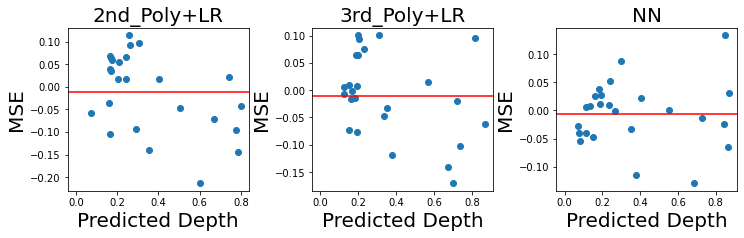

In [18]:
"""As model2, model7, model8 have close R2 scores, lets compare their test loss"""
fig = plt.figure(figsize=(12,3))
plt.subplots_adjust(wspace = 0.35)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

######################
Model2 = model2.fit(Xtrain.iloc[:,:5], Y_train)
predict2 = Model2.predict(Xtest.iloc[:,:5])
loss = mean_squared_error(Y_test, predict2)
res2 = predict2.ravel() - Y_test.ravel()

ax1.scatter(predict2, res2)
ax1.axhline(y=res2.mean(), color='r', linestyle='-')
ax1.set_title('2nd_Poly+LR', fontsize=20)
ax1.plot(res2.mean())

ax1.set_xlabel('Predicted Depth', fontsize=20)
ax1.set_ylabel('MSE', fontsize=20)

##################


Model3 = model_poly3.fit(Xtrain.iloc[:,:5], Y_train)
predict3 = Model3.predict(Xtest.iloc[:,:5])
loss = mean_squared_error(Y_test, predict3)
res3 = predict3.ravel() - Y_test.ravel()

ax2.scatter(predict3, res3)
ax2.axhline(y=res3.mean(), color='r', linestyle='-')
ax2.set_title('3rd_Poly+LR', fontsize=20)
ax2.plot(res3.mean())

ax2.set_xlabel('Predicted Depth', fontsize=20)
ax2.set_ylabel('MSE', fontsize=20)

# ##################
predict4 = NN_MultiLayer_pred(Xtrain.iloc[:,:5], Y_train, Xtest.iloc[:,:5])
loss = mean_squared_error(Y_test, predict4)
res4 = predict4.ravel() - Y_test.ravel()

ax3.scatter(predict4, res4)
ax3.axhline(y=res4.mean(), color='r', linestyle='-')
ax3.set_title('NN', fontsize=20)
ax3.plot(res4.mean())

ax3.set_xlabel('Predicted Depth', fontsize=20)
ax3.set_ylabel('MSE', fontsize=20)

# plt.savefig('Graphs/residualplot.png',bbox_inches='tight')
plt.show()

## Prediciting depth

In [16]:

### predict Depth
Y_train = np.c_[Dpt_train]
Y_test = np.c_[Dpt_test]

In [17]:
case_pred = []

for i in range(100):

    pred = NN_MultiLayer_pred(Xtrain.iloc[:,:5],Y_train, 
                             Xtest.iloc[:,0:5], )

    case_pred.append(pred)

B = np.array(case_pred)

meanDpt_pred = []
stdDpt_pred = []

for l in range(B.shape[1]):
    meanDpt_pred.append(B[:, l, 0].mean())
    stdDpt_pred.append(B[:, l, 0].std(ddof=1))
    
stdDpt_pred = [element * 2 for element in stdDpt_pred]

2021-11-01 08:58:54.930700: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-01 08:58:54.996395: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


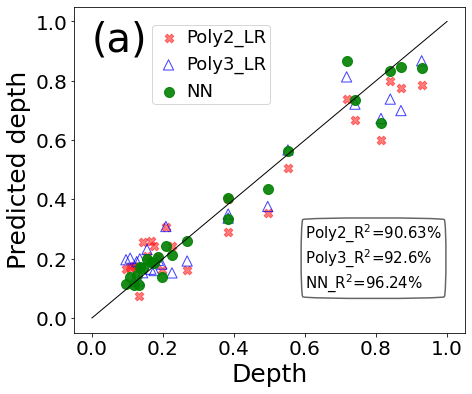

In [18]:
fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(111)

plt.subplots_adjust(wspace=0.25)
bbox_propsLAD = dict(boxstyle="round4,pad=0.3", fc="white", ec="k", lw=1.5, alpha=0.6)

###################
Model2 = model2.fit(Xtrain.iloc[:,:5], Y_train)
predict2 = Model2.predict(Xtest.iloc[:,:5])

ax1.scatter(Y_test,predict2,color='r', marker='X',s=75,alpha=0.5, label = 'Poly2_LR')

###################
Model3 = model_poly3.fit(Xtrain.iloc[:,:5], Y_train)
predict3 = Model3.predict(Xtest.iloc[:,:5])

ax1.scatter(Y_test,predict3, marker='^',s=105,
            facecolors='none', edgecolors='b', alpha=0.75, label = 'Poly3_LR')

###################
ax1.scatter(Y_test,meanDpt_pred,color='g', marker='o',s=100,alpha=0.9, label = 'NN')

##### In case we want to show the error bars

# ax1.errorbar(Y_test, meanDpt_pred,
#             yerr= stdDpt_pred,
#              capsize=5,
#             fmt='og', ms=10, lw =2, label = 'NN')

####################

ax1.annotate('Poly2_R$^2$='+str(round(r2_score(Y_test, predict2)*100,2))+'%'+
             '\nPoly3_R$^2$='+str(round(r2_score(Y_test, predict3)*100,2))+'%'+
             '\nNN_R$^2$='+str(round(r2_score(Y_test, meanDpt_pred)*100,2))+'%', 
             xy=(0.60,0.1),fontsize=15,bbox=bbox_propsLAD)
###############################
x=np.linspace(0,1,10)
ax1.plot(x,x*(x>0),linewidth=1, color='k')

ax1.set_xlabel('Depth', fontsize=25)
ax1.set_ylabel('Predicted depth', fontsize=25)

ax1.legend(loc=(0.2,0.7), fontsize=18, handlelength=1.4, handletextpad=0.3, borderpad=0.2)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.text(0,0.9,'(a)',fontsize= 40)

# plt.savefig('Graphs/Depth_Models.png',bbox_inches='tight')

plt.show()

## Predicting Top width

In [19]:
####### predict Top width
Y_train = np.c_[Topw_train]
Y_test = np.c_[Topw_test]


case_pred = []
for i in range(100):

    pred = NN_MultiLayer_pred(Xtrain.iloc[:,:5],Y_train, 
                             Xtest.iloc[:,0:5], )

    case_pred.append(pred)

B = np.array(case_pred)

mean_pred = []
std_pred = []

for l in range(B.shape[1]):
    mean_pred.append(B[:, l, 0].mean())
    std_pred.append(B[:, l, 0].std(ddof=1))
    
std_pred = [element * 2 for element in std_pred]

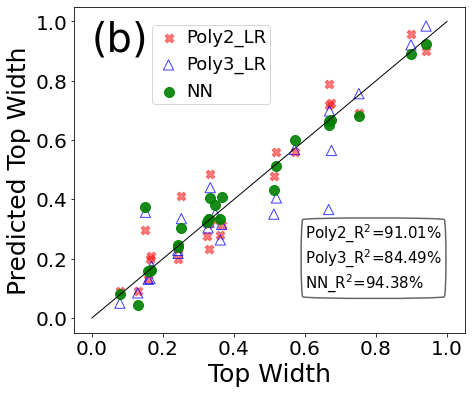

In [20]:
fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(111)

plt.subplots_adjust(wspace=0.25)
bbox_propsLAD = dict(boxstyle="round4,pad=0.3", fc="white", ec="k", lw=1.5, alpha=0.6)

###################
Model2 = model2.fit(Xtrain.iloc[:,:5], Y_train)
predict2 = Model2.predict(Xtest.iloc[:,:5])

ax1.scatter(Y_test,predict2,color='r', marker='X',s=75,alpha=0.5, label = 'Poly2_LR')

###################
Model3 = model_poly3.fit(Xtrain.iloc[:,:5], Y_train)
predict3 = Model3.predict(Xtest.iloc[:,:5])
ax1.scatter(Y_test,predict3, marker='^',s=105,
            facecolors='none', edgecolors='b', alpha=0.75, label = 'Poly3_LR')



###################
ax1.scatter(Y_test,mean_pred,color='g', marker='o',s=100,alpha=0.9, label = 'NN')

##### In case we want to show the error bars

# ax1.errorbar(Y_test, mean_pred,
#             yerr= std_pred,
#              capsize=5,
#             fmt='og', ms=10, lw =2, label = 'NN')

####################

ax1.annotate('Poly2_R$^2$='+str(round(r2_score(Y_test, predict2)*100,2))+'%'+
             '\nPoly3_R$^2$='+str(round(r2_score(Y_test, predict3)*100,2))+'%'+
             '\nNN_R$^2$='+str(round(r2_score(Y_test, mean_pred)*100,2))+'%', 
             xy=(0.60,0.1),fontsize=15,bbox=bbox_propsLAD)
###############################
x=np.linspace(0,1,10)
ax1.plot(x,x*(x>0),linewidth=1, color='k')

ax1.set_xlabel('Top Width', fontsize=25)
ax1.set_ylabel('Predicted Top Width', fontsize=25)

ax1.legend(loc=(0.2,0.7), fontsize=18, handlelength=1.4, handletextpad=0.3, borderpad=0.2)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.text(0,0.9,'(b)',fontsize= 40)

plt.savefig('Graphs/TopWidth_Models.png',bbox_inches='tight')

plt.show()

## Predicting bottom width

In [21]:
####### predict Bottom width
Y_train = np.c_[Botw_train]
Y_test = np.c_[Botw_test]

case_pred = []
for i in range(100):

    pred = NN_MultiLayer_pred(Xtrain.iloc[:,:5],Y_train, 
                             Xtest.iloc[:,0:5], )

    case_pred.append(pred)

B = np.array(case_pred)

mean_pred = []
std_pred = []

for l in range(B.shape[1]):
    mean_pred.append(B[:, l, 0].mean())
    std_pred.append(B[:, l, 0].std(ddof=1))
    
std_pred = [element * 2 for element in std_pred]

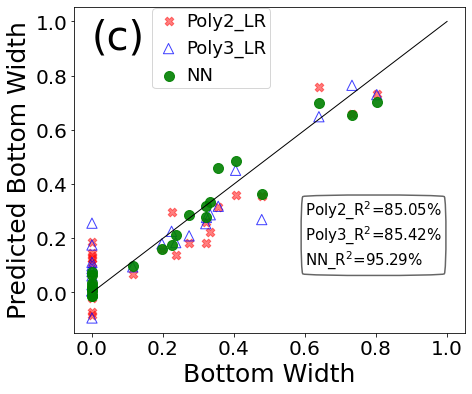

In [22]:
fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(111)

plt.subplots_adjust(wspace=0.25)
bbox_propsLAD = dict(boxstyle="round4,pad=0.3", fc="white", ec="k", lw=1.5, alpha=0.6)
###################
Model2 = model2.fit(Xtrain.iloc[:,:5], Y_train)
predict2 = Model2.predict(Xtest.iloc[:,:5])

ax1.scatter(Y_test,predict2,color='r', marker='X',s=75,alpha=0.5, label = 'Poly2_LR')
###################
Model3 = model_poly3.fit(Xtrain.iloc[:,:5], Y_train)
predict3 = Model3.predict(Xtest.iloc[:,:5])

ax1.scatter(Y_test,predict3, marker='^',s=105,
            facecolors='none', edgecolors='b', alpha=0.75, label = 'Poly3_LR')

ax1.scatter(Y_test,mean_pred,color='g', marker='o',s=100,alpha=0.9, label = 'NN')

##### In case we want to show the error bars

# ax1.errorbar(Y_test, mean_pred,
#             yerr= std_pred,
#              capsize=2,
#             fmt='og', ms=10, lw =2, label = 'NN')

####################

ax1.annotate('Poly2_R$^2$='+str(round(r2_score(Y_test, predict2)*100,2))+'%'+
             '\nPoly3_R$^2$='+str(round(r2_score(Y_test, predict3)*100,2))+'%'+
             '\nNN_R$^2$='+str(round(r2_score(Y_test, mean_pred)*100,2))+'%', 
             xy=(0.60,0.1),fontsize=15,bbox=bbox_propsLAD)
###############################
x=np.linspace(0,1,10)
ax1.plot(x,x*(x>0),linewidth=1, color='k')

ax1.set_xlabel('Bottom Width', fontsize=25)
ax1.set_ylabel('Predicted Bottom Width', fontsize=25)

ax1.legend(loc=(0.2,0.75), fontsize=18, handlelength=1.4, handletextpad=0.3, borderpad=0.2)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax1.text(0,0.9,'(c)',fontsize= 40)

plt.savefig('Graphs/BotWidth_Models.png',bbox_inches='tight')
plt.show()

In [ ]:
def NN_MultiLayer_pred(Xtrain, Y_train, Xtest):
    input = Input(shape=(5,))
    x = Dense(64, activation='relu')(input)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(Xtrain, (Y_train) , epochs=1000, batch_size=64 ,verbose=0)
    pred = model.predict(Xtest)
    return pred